In [1]:
from fastai.collab import *
from fastai.tabular import *

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# Load agent stats

In [3]:
agents_stats = pd.read_csv('data/AgentStats.csv')
agents_stats.head()

,Time,Tag,Turn,Type,Motivation,Happiness,Attention,Action,Desire,Action_idx,Desire_idx,IsStudying,IsQuarrel,Instance,Experiment
0,0,Agent00,0,S,0.88,0.80,0.0,Break(INACTIVE),Break(INACTIVE),0,0,False,False,Instance-000-5956,ADHD-None
1,0,Agent00,1,S,0.88,0.80,0.0,Break(INACTIVE),Break(INACTIVE),0,0,False,False,Instance-000-5956,ADHD-None
2,0,Agent01,0,S,0.81,0.06,0.0,Break(INACTIVE),Break(INACTIVE),0,0,False,False,Instance-000-5956,ADHD-None
3,0,Agent01,1,S,0.81,0.06,0.0,Break(INACTIVE),Break(INACTIVE),0,0,False,False,Instance-000-5956,ADHD-None
4,0,Agent02,0,S,0.79,0.47,0.0,Break(INACTIVE),Break(INACTIVE),0,0,False,False,Instance-000-5956,ADHD-None


In [4]:
user_id = agents_stats[['Experiment', 'Instance', 'Tag']].apply(lambda x: '_'.join(x), axis=1)
user_id.name = 'userid'

In [5]:
agent_data = pd.concat([user_id, agents_stats[['Turn', 'Action_idx']]], axis=1).rename(columns={'Turn': 'item', 'Action_idx': 'rating'})

In [6]:
agent_data.head()

,userid,item,rating
0,ADHD-None_Instance-000-5956_Agent00,0,0
1,ADHD-None_Instance-000-5956_Agent00,1,0
2,ADHD-None_Instance-000-5956_Agent01,0,0
3,ADHD-None_Instance-000-5956_Agent01,1,0
4,ADHD-None_Instance-000-5956_Agent02,0,0


In [7]:
data = CollabDataBunch.from_df(agent_data, seed=42)

In [8]:
y_range = [-0.5,19.5]

In [9]:
learn = collab_learner(data, n_factors=10, y_range=y_range, wd=1e-1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


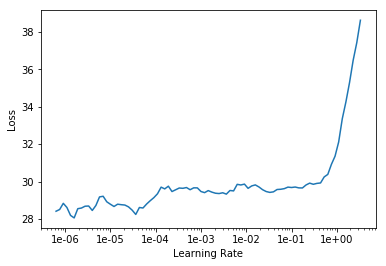

In [10]:
learn.lr_find()
learn.recorder.plot()

In [11]:
learn.fit_one_cycle(3, 5e-5)

epoch,train_loss,valid_loss,time
0,28.940830,29.333035,01:34
1,29.271770,28.839472,01:40
2,28.500469,28.760481,01:28


# Model Interpretation

In [12]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(3001, 10)
  (i_weight): Embedding(1003, 10)
  (u_bias): Embedding(3001, 1)
  (i_bias): Embedding(1003, 1)
)

In [13]:
userids = agent_data['userid'].unique()

In [14]:
user_pca = learn.model.u_weight.weight.pca(2)
X = user_pca[:, 0]
Y = user_pca[:, 1]

In [15]:
uids = learn.data.x.classes['userid'][1:]

In [16]:
uids_df = pd.DataFrame([s.split('_') for s in uids], columns=['Experiment', 'Instance', 'Tag'])
uids_df.head()

,Experiment,Instance,Tag
0,ADHD-High,Instance-000-5956,Agent00
1,ADHD-High,Instance-000-5956,Agent01
2,ADHD-High,Instance-000-5956,Agent02
3,ADHD-High,Instance-000-5956,Agent03
4,ADHD-High,Instance-000-5956,Agent04


In [17]:
agent_info = pd.read_csv('data/AgentInfo.csv')
agent_info.head()

,Tag,studentname,personalitytype,conformity,Openness,Conscientiousness,Extraversion,Agreeableness,Neuroticism,Instance,Experiment,B(T),B(W),B(E),C(T),C(W),C(E),SA(T),SA(W),SA(E),SG(T),SG(W),SG(E),Q(T),Q(W),Q(E)
0,Agent00,Michael,Normal,0.43325,0.75,0.6,0.55,0.65,0.5,Instance-000-5956,ADHD-None,0.0,0.0,16.283716,5.094905,3.996004,24.675325,3.496503,2.297702,11.188811,3.996004,5.694306,12.787213,0.799201,1.298701,8.191808
1,Agent01,Maria,Normal,0.43325,0.75,0.6,0.55,0.65,0.5,Instance-000-5956,ADHD-None,0.0,0.0,13.686314,4.295704,3.296703,27.972028,3.196803,3.496503,7.492507,3.296703,3.896104,12.787213,2.597403,2.797203,10.989011
2,Agent02,Julian,Normal,0.43325,0.75,0.6,0.55,0.65,0.5,Instance-000-5956,ADHD-None,0.0,0.0,15.784216,4.495504,4.795205,27.372627,2.897103,1.298701,7.892108,3.696304,3.496503,11.888112,1.698302,2.597403,11.888112
3,Agent03,Benjamin,Normal,0.43325,0.75,0.6,0.55,0.65,0.5,Instance-000-5956,ADHD-None,0.0,0.0,15.384615,3.796204,2.797203,26.273726,4.295704,0.899101,8.991009,3.896104,4.795205,11.688312,1.398601,1.898102,13.686314
4,Agent04,Maria,Normal,0.43325,0.75,0.6,0.55,0.65,0.5,Instance-000-5956,ADHD-None,0.0,0.0,13.086913,4.795205,4.595405,25.674326,3.396603,1.998002,8.391608,3.596404,4.495504,11.288711,2.797203,2.997003,12.687313


In [18]:
full_uids = uids_df.merge(agent_info[['Experiment', 'Instance', 'Tag', 'personalitytype']])
full_uids.head()

,Experiment,Instance,Tag,personalitytype
0,ADHD-High,Instance-000-5956,Agent00,ADHD
1,ADHD-High,Instance-000-5956,Agent01,ADHD
2,ADHD-High,Instance-000-5956,Agent02,ADHD
3,ADHD-High,Instance-000-5956,Agent03,ADHD
4,ADHD-High,Instance-000-5956,Agent04,ADHD


In [19]:
full_uids['groupname'] = full_uids['Experiment'] + '_'+ full_uids['personalitytype']
full_uids.head()

,Experiment,Instance,Tag,personalitytype,groupname
0,ADHD-High,Instance-000-5956,Agent00,ADHD,ADHD-High_ADHD
1,ADHD-High,Instance-000-5956,Agent01,ADHD,ADHD-High_ADHD
2,ADHD-High,Instance-000-5956,Agent02,ADHD,ADHD-High_ADHD
3,ADHD-High,Instance-000-5956,Agent03,ADHD,ADHD-High_ADHD
4,ADHD-High,Instance-000-5956,Agent04,ADHD,ADHD-High_ADHD


In [20]:
ngroups = len(full_uids['groupname'].unique())
ngroups

20

In [21]:
import matplotlib.colors as mcolors
group_colors = list(mcolors.TABLEAU_COLORS.values())


cmap = plt.cm.get_cmap('gist_rainbow')
group_colors = cmap(np.linspace(0, 1, ngroups))

ADHD-High_ADHD: 100
ADHD-High_Normal: 200
ADHD-Low-Ambitious_ADHD: 20
ADHD-Low-Ambitious_Ambitious: 140
ADHD-Low-Ambitious_Normal: 140
ADHD-Low_ADHD: 20
ADHD-Low_Normal: 280
ADHD-Medium-Ambitious_ADHD: 60
ADHD-Medium-Ambitious_Ambitious: 120
ADHD-Medium-Ambitious_Normal: 120
ADHD-Medium_ADHD: 60
ADHD-Medium_Normal: 240
ADHD-None-Ambitious_Ambitious: 150
ADHD-None-Ambitious_Normal: 150
ADHD-None_Normal: 300
ADHD-VeryHigh-Ambitious_ADHD: 150
ADHD-VeryHigh-Ambitious_Ambitious: 150
ADHD-VeryHigh_ADHD: 150
ADHD-VeryHigh_Normal: 150
Random_Random: 300


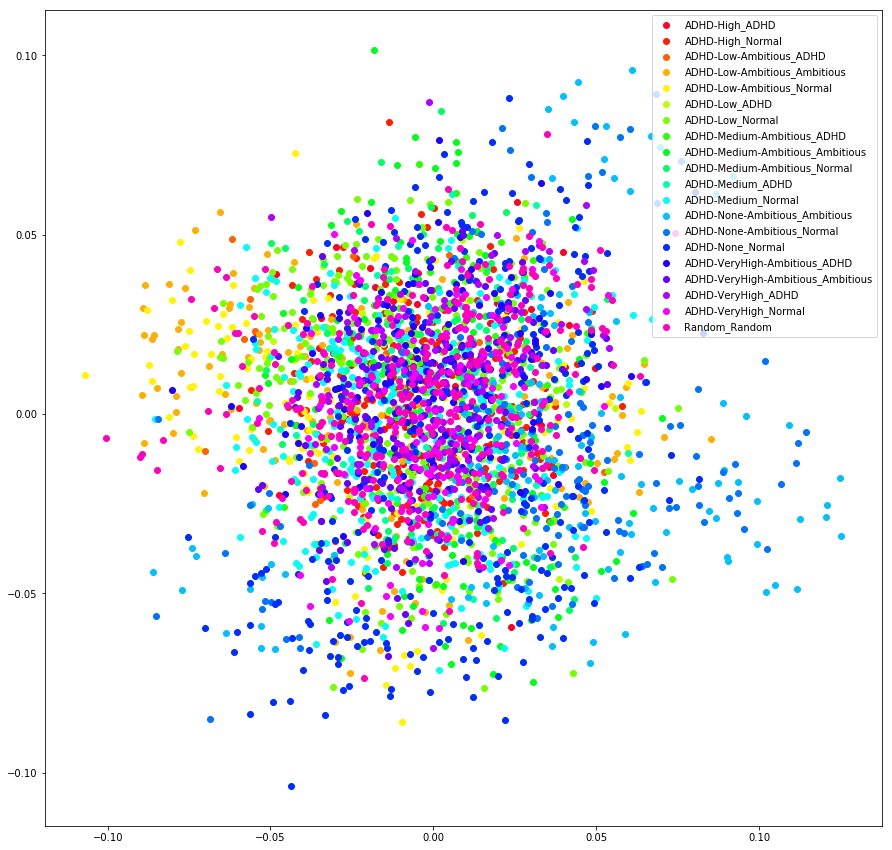

In [22]:
G = full_uids.groupby('groupname')

plt.figure(figsize=(15,15))

for idx, (name, data) in enumerate(G):
    plt.scatter(X[data.index], Y[data.index], c=group_colors[idx], label=name)
    print(f'{name}: {len(data.index)}')
    
plt.legend()
plt.show()


In [23]:
ngroups

20

In [24]:
plt.scatter?